In [11]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf


In [12]:
import os
files = []
folder_path = os.getcwd()
files_2 = [os.path.join(folder_path+"\\dane_2", file) for file in os.listdir(folder_path+"\\dane_2") if file.endswith('.csv')]


In [13]:
files_1 = [os.path.join(folder_path+"\\dane_1", file) for file in os.listdir(folder_path+"\\dane_1") if file.endswith('.csv')]


In [14]:
df_combined_1 = pd.DataFrame()
for file in files_1:
    data = pd.read_csv(file, index_col=0, parse_dates=True, sep=';')
    df_combined_1 = pd.concat([df_combined_1, data], axis=0)

df_combined_1.drop_duplicates(inplace=True)
# Usuń wiersze, które mają nieprawidłowe wartości w kolumnie 'Godz.'
df_combined_1 = df_combined_1[df_combined_1['Godz.'].apply(lambda x: str(x).isdigit())]

# Konwertuj kolumnę 'Godz.' na typ int
df_combined_1['Godz.'] = df_combined_1['Godz.'].astype(int)

# Dodaj kolumnę 'Data'
df_combined_1['Data'] = pd.to_datetime(df_combined_1.index) + pd.to_timedelta(df_combined_1['Godz.'] - 1, unit='h')

# Sprawdź, czy kolumny istnieją przed próbą ich usunięcia
# Usuń kolumnę 'Godz.' i resetuj indeks
df_combined_1.drop(columns=['Godz.'], inplace=True)
df_combined_1.set_index('Data', inplace=True)
# Zmień nazwy kolumn
df_combined_1.rename(columns={
    'Dobowa prognoza zapotrzebowania KSE': 'value',
    'Rzeczywiste zapotrzebowanie KSE': 'forecast'
}, inplace=True)

# Zamień wartości w kolumnach 'forecast' i 'value' na float, ignorując błędy
df_combined_1['forecast'] = df_combined_1['forecast'].str.replace(',', '.').apply(pd.to_numeric, errors='coerce')
df_combined_1['value'] = df_combined_1['value'].astype(float)

# df_combined_1.index.name = None


In [15]:
df_combined = pd.DataFrame()
for file in files_2:
    data = pd.read_csv(file, index_col=0, parse_dates=True, sep=';')
    df_combined = pd.concat([df_combined, data], axis=0)

df_combined.drop_duplicates(inplace=True)



In [16]:
# Połącz pierwszą i drugą kolumnę, aby utworzyć kolumnę daty
df_combined['Data'] = df_combined.index.astype(str) + ' ' + df_combined['OREB [Jednostka czasu od-do]'].str.split(' - ').str[0]

# Przekonwertuj nową kolumnę na typ daty, ignorując błędy
df_combined['Data'] = pd.to_datetime(df_combined['Data'], format='%Y-%m-%d %H:%M', errors='coerce')

# Sprawdź, czy kolumny istnieją przed próbą ich usunięcia
columns_to_drop = ["Data publikacji", "Doba handlowa"]
df_combined.drop(columns=[col for col in columns_to_drop if col in df_combined.columns], axis=1, inplace=True)


df_combined['Hour'] = df_combined.groupby(df_combined.index).cumcount() // 4 + 1
df_grouped = df_combined.groupby(["Hour",df_combined.index]).agg(value=('Rzeczywiste zapotrzebowanie KSE [MW]', 'median'),forecast=('Prognozowane zapotrzebowanie KSE [MW]', 'median'))
# Usuń kolumny 'Hour' i 'OREB [Jednostka czasu od-do]'
df_grouped.reset_index(inplace=True)

# Dodaj kolumnę z datą i godziną
df_grouped['Data'] = pd.to_datetime(df_grouped['Doba handlowa']) + pd.to_timedelta(df_grouped['Hour'] - 1, unit='h')

# Ustaw kolumnę 'Data' jako indeks
df_grouped.set_index('Data', inplace=True)
df_grouped.drop(columns=['Hour'], inplace=True)
df_grouped.sort_index(inplace=True)
# Wyświetl wynik
df_grouped.drop(columns=['Doba handlowa'], inplace=True)
df_grouped.reset_index(inplace=True)
df_grouped.set_index('Data', inplace=True)


In [17]:
# Reset the index of both dataframes before merging
df_grouped_reset = df_grouped.reset_index()
df_combined_1_reset = df_combined_1.reset_index()

# Merge df_grouped and df_combined_1 using concat
merged_df = pd.concat([df_grouped_reset, df_combined_1_reset], axis=0)

# Display the merged dataframe
display(merged_df.sort_values('Data'))

,Data,value,forecast
0,2023-07-19 00:00:00,16800.0000,16191.613
1,2023-07-19 01:00:00,16050.0000,15528.975
2,2023-07-19 02:00:00,15450.0000,15060.725
3,2023-07-19 03:00:00,15350.0000,14978.700
4,2023-07-19 04:00:00,15300.0000,14916.263
...,...,...,...
6572,2025-03-19 19:00:00,22573.9750,22725.000
6573,2025-03-19 20:00:00,21965.4530,22250.000
6574,2025-03-19 21:00:00,20380.5045,20475.000
6575,2025-03-19 22:00:00,18966.3265,19125.000


In [18]:
# Split the data into train and test sets
train_size = int(len(merged_df) * 0.8)
train_df = merged_df[:train_size]
test_df = merged_df[train_size:]

# Save the train and test sets to CSV files
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

merged_df.to_csv('merged_df.csv', index=False)

In [176]:
y = merged_df["value"].to_numpy()
x = np.arange(0, len(merged_df["value"]), 1)

In [177]:
series = pd.Series(merged_df["value"], index=merged_df.index)

In [178]:
# Obliczenie autokorelacji
t = 12
autocorr = acf(series, nlags=10000)  # Sprawdzamy do 24 lagów
best_period = np.argmax(autocorr[t:]) +t  # Pomijamy lag 0

print(f"Najlepszy okres na podstawie autokorelacji: {best_period}")

Najlepszy okres na podstawie autokorelacji: 168


In [99]:
autocorr[12:]

array([0.738049  , 0.70306854, 0.66754899, ..., 0.14262527, 0.12762222,
       0.1123391 ])

In [98]:
autocorr[672]

0.8270611133389572

In [179]:
decomposition = seasonal_decompose(series, model='additive', period=168)

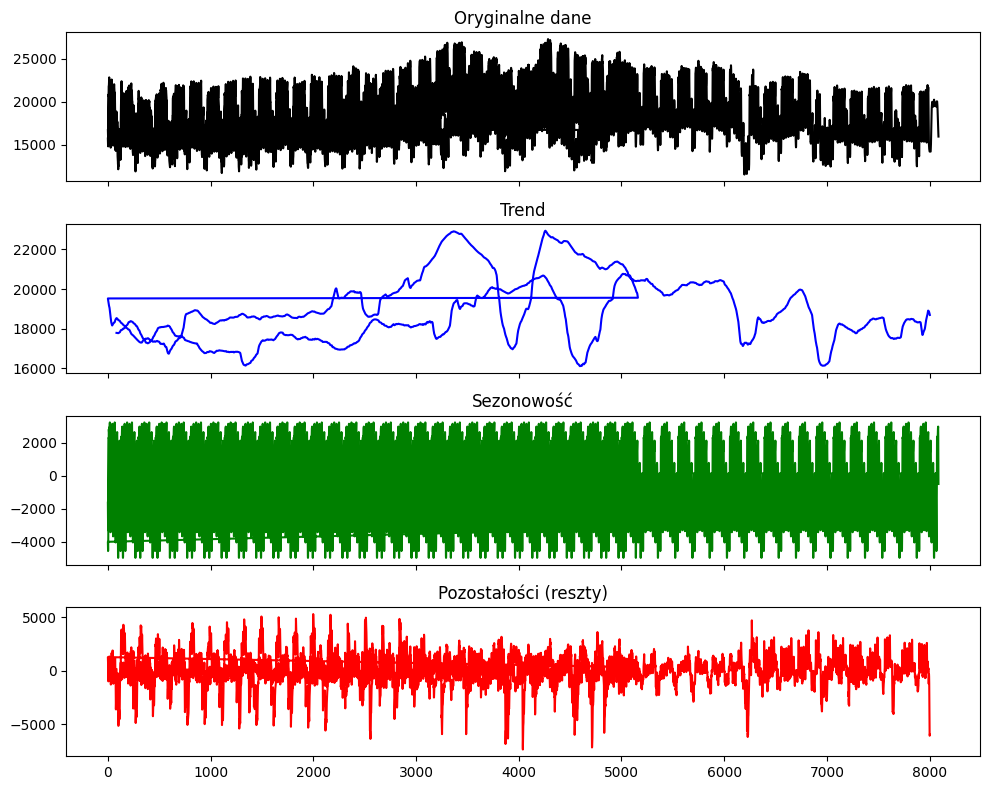

In [180]:
# Wykres wyników dekompozycji
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
series.plot(ax=axes[0], title='Oryginalne dane', color='black')
decomposition.trend.plot(ax=axes[1], title='Trend', color='blue')
decomposition.seasonal.plot(ax=axes[2], title='Sezonowość', color='green')
decomposition.resid.plot(ax=axes[3], title='Pozostałości (reszty)', color='red')
plt.tight_layout()
plt.show()

In [181]:
suma_reszt_abs = np.abs(decomposition.resid).sum()


In [182]:
suma_reszt_abs

13119325.156678572

In [183]:
residuals_np.sum()

NameError: name 'residuals_np' is not defined

<Axes: title={'center': 'Pozostałości (reszty)'}, xlabel='Data'>

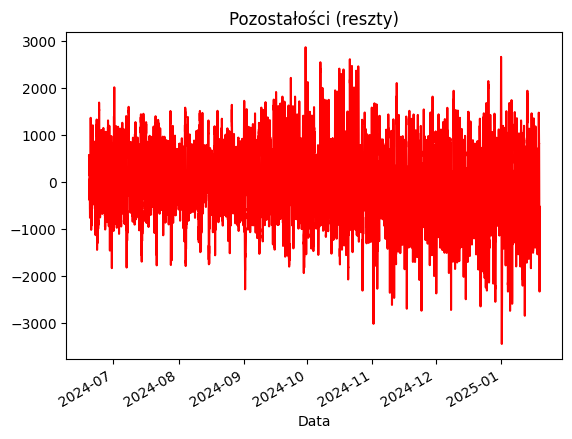

In [38]:
decomposition.resid.plot( title='Pozostałości (reszty)', color='red')
